## Import Packages and Load Data

In [1]:
# before running everything, create a new conda environment with python 3.10 installed 
# conda env create -n "myEnv" python=3.10
# pip install torch torchvision matplotlib seaborn umap-learn umap-learn[plot] xgboost scikit-learn nltk
# conda install numpy pandas 

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from preprocess import * 
import xgboost
import umap
import umap.plot

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/muchang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/muchang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/muchang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the

In [2]:
train_data = pd.read_csv(os.path.join("data", "train.csv"))
test_data = pd.read_csv(os.path.join("data", "test.csv"))
train_data.dropna(inplace=True)
X, y = train_data.drop(["price"], axis=1), train_data["price"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
X_test = test_data
X_train, X_val = preprocess(X_train), preprocess(X_val) 

### Boxplots of Postprocessed features

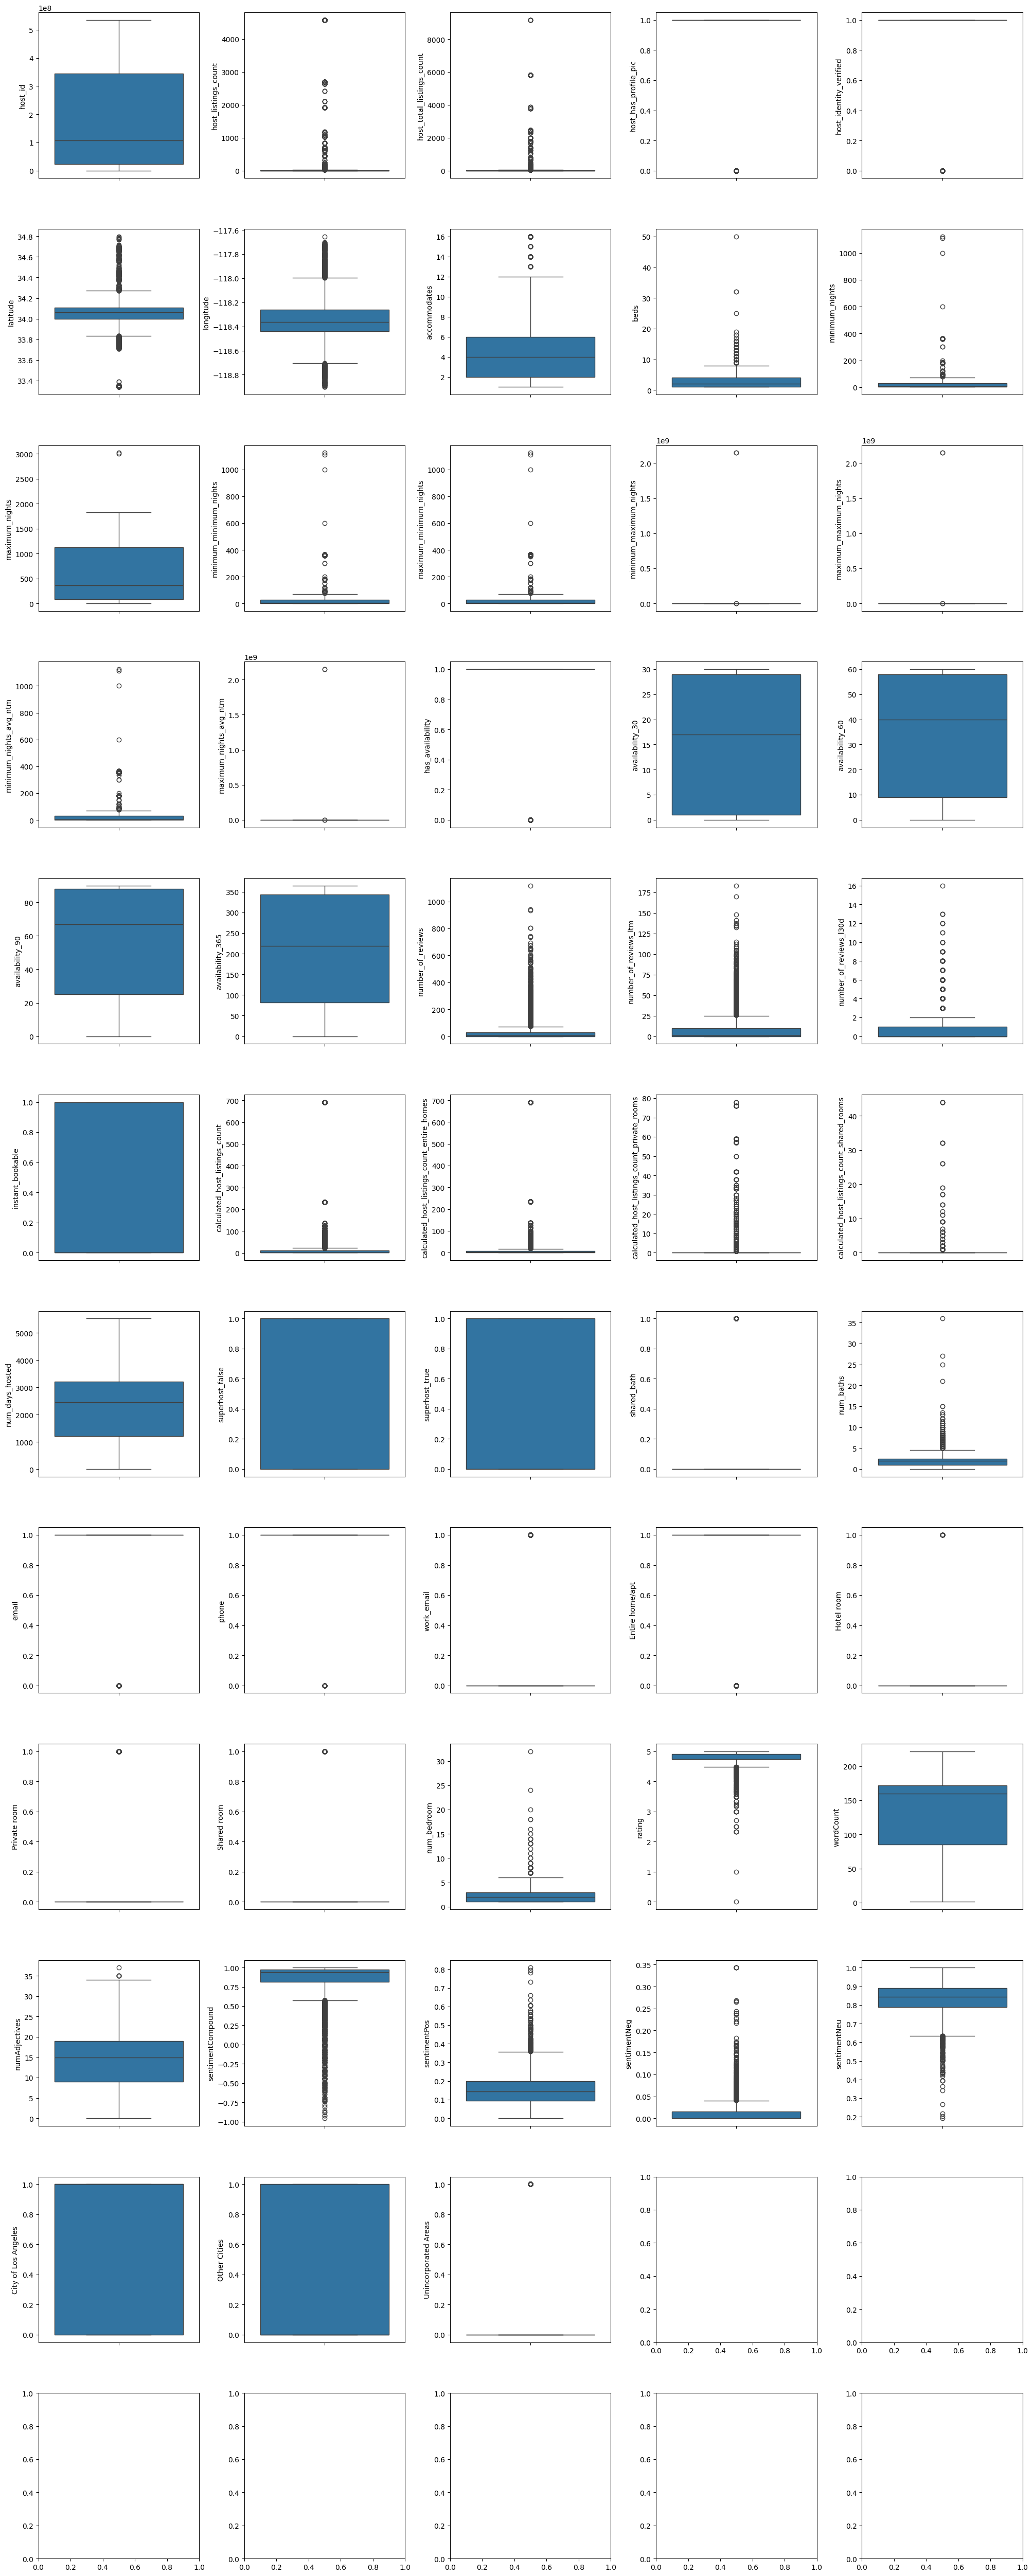

In [3]:
fig, axs = plt.subplots(ncols=5, nrows=12, figsize=(20, 50))
index = 0
axs = axs.flatten()  
for k,v in X_train.items():
    sns.boxplot(y=k, data=X_train, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

### Visualize Data with UMAP

/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<Axes: >

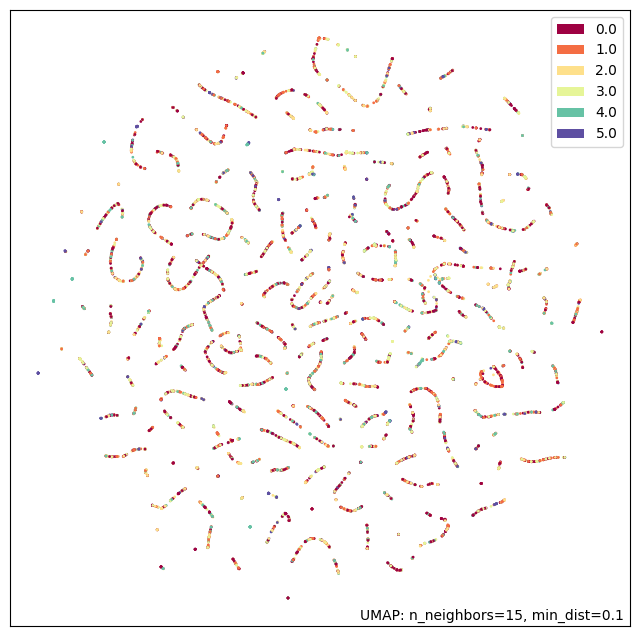

In [9]:
mapper_raw = umap.UMAP().fit(X_train)
umap.plot.points(mapper_raw, labels=y_train)

## Train Neural Net Feature Extractor

### Prepare dataloaders and set device

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class AirBnbDataset(Dataset): 
    
    def __init__(self, X, y): 
        
        # First, train the scaler to the preprocessed train set only 
        scaler = StandardScaler() 
        scaler.fit(X_train) 
        
        # now, convert this pandas dataframe to a numpy array and scale it 
        X = X.to_numpy().astype(float)
        X = scaler.transform(X) 
        
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = y.to_numpy().astype(int)
        self.num_features = self.X.size()[1]
        
    def process_into_tensor(self): 
        scaler = StandardScaler() 
        scaler.fit(X) 
    
    def __len__(self): 
        return self.X.size()[0] 
    
    def __getitem__(self, i): 
        return (self.X[i, :], self.y[i])

trainset = AirBnbDataset(X_train, y_train) 
valset = AirBnbDataset(X_val, y_val)

trainloader = DataLoader(trainset,    # our dataset
                              batch_size=512,    # batch size
                              shuffle=True      # shuffling the data
                            )
valloader = DataLoader(valset, batch_size=512, shuffle=True)

/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(), 
            nn.Linear(512, 6)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
def oneHot(y): 
    one_hot = torch.zeros(len(y), 6)
    for idx, class_num in enumerate(y):
        one_hot[idx, class_num] = 1 
    return one_hot

def train(dataloader, model, loss_fn, optimizer, scheduler):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, oneHot(y).to(device))

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    return loss 
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, oneHot(y).to(device)).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss 

In [10]:
model = NeuralNetwork(trainset.num_features).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),     # which parameters to optimize
    lr=1e-2,                 # learning rate 
    momentum=0.9, 
    weight_decay=1e-3
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.9)

epochs = 500
train_losses, val_losses = [], []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses.append(train(trainloader, model, loss_fn, optimizer, scheduler))
    val_losses.append(test(valloader, model, loss_fn))
    scheduler.step() 
    # print(f"lr : {optimizer.lr}")
print("Done!")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Construct Backbone Network Feature Extractor

In [44]:
# Get just the feature extractor 
model_cp = NeuralNetwork(trainset.num_features).to(device)
for new_param, param in zip(model_cp.parameters(), model.parameters()):
    new_param.data.copy_(param.data)

model_cp.linear_relu_stack = nn.Sequential(*list(model_cp.linear_relu_stack.children())[:-1])
scaler = StandardScaler() 
scaler.fit(X_train) 


input = X_train.to_numpy().astype(float)
input = scaler.transform(input) 
input = torch.tensor(input, dtype=torch.float32).to(device)
X_train_features = model_cp(input).detach().cpu().numpy()

input = X_val.to_numpy().astype(float)
input = scaler.transform(input) 
input = torch.tensor(input, dtype=torch.float32).to(device)
X_val_features = model_cp(input).detach().cpu().numpy()

/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<Axes: >

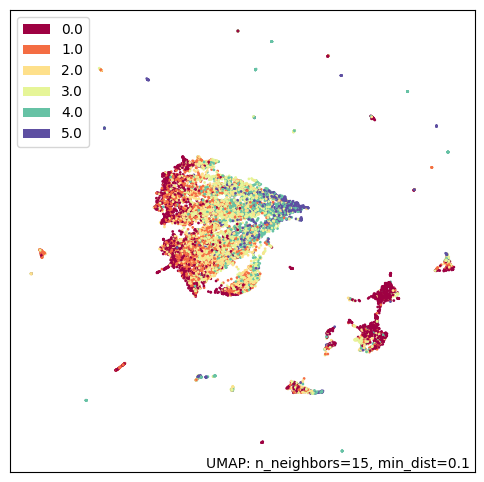

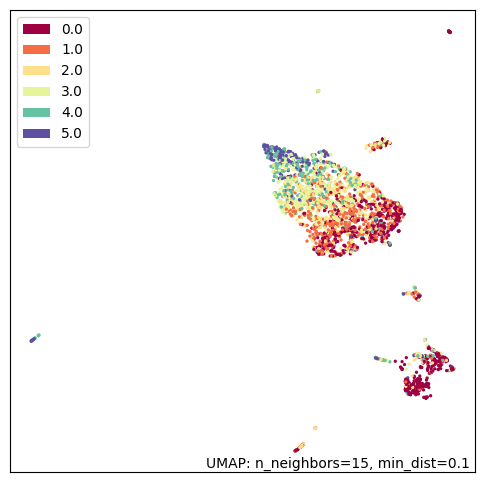

In [45]:
umap.plot.points(umap.UMAP().fit(X_train_features), labels=y_train, width=600, height=600)
umap.plot.points(umap.UMAP().fit(X_val_features), labels=y_val, width=600, height=600)

## Train Classical Models on Transformed Dataset

In [48]:
X_val

,host_id,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,beds,minimum_nights,...,rating,wordCount,numAdjectives,sentimentCompound,sentimentPos,sentimentNeg,sentimentNeu,City of Los Angeles,Other Cities,Unincorporated Areas
5684,17350370,1.0,1.0,1,1,33.988050,-118.417620,4,2.0,30,...,4.74,179,23,0.9686,0.153,0.020,0.827,True,False,False
1542,288514469,3.0,5.0,1,1,33.767290,-118.188470,6,3.0,3,...,4.73,126,8,0.9349,0.116,0.000,0.884,False,True,False
13490,24698673,1.0,1.0,1,0,34.103110,-118.349910,1,1.0,30,...,4.74,149,11,0.8100,0.066,0.000,0.934,True,False,False
7110,207248018,5.0,11.0,1,0,34.190310,-118.577314,8,5.0,3,...,4.71,174,23,0.8854,0.083,0.024,0.893,True,False,False
3687,22458254,3.0,3.0,1,1,34.088520,-118.127460,3,2.0,1,...,4.92,14,1,0.0000,0.000,0.000,1.000,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15179,9653149,1.0,1.0,1,1,34.074630,-118.603120,4,2.0,3,...,4.92,181,25,0.9884,0.189,0.000,0.811,False,False,True
4683,39253,2.0,3.0,1,1,33.838890,-118.385370,2,1.0,4,...,4.70,165,17,0.9916,0.229,0.025,0.746,False,True,False
5550,206500358,1.0,2.0,1,1,34.060880,-118.736230,7,5.0,3,...,4.74,173,25,0.9878,0.189,0.000,0.811,False,False,True
15079,105890241,7.0,17.0,1,1,34.085500,-118.358020,2,1.0,30,...,4.60,87,11,0.9531,0.191,0.000,0.809,True,False,False


In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


def decisionTree(hyperparameters):

    mod = DecisionTreeClassifier()

    clf = GridSearchCV(mod, hyperparameters, cv=5, verbose=3, n_jobs=20, scoring="accuracy")

    best_mod = clf.fit(X_train_features, y_train)

    print('Best Parameter Estimates:', best_mod.best_estimator_.get_params())

    val_input = X_val.to_numpy().astype(float)
    val_input = scaler.transform(val_input)
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device)

    y_pred = best_mod.predict(model_cp(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))

def randomForest(hyperparameters): 
    mod = RandomForestClassifier()

    clf = GridSearchCV(mod, hyperparameters, cv=5, verbose=3, n_jobs=20, scoring="accuracy")

    best_mod = clf.fit(X_train_features,y_train)

    print('Best Parameter Estimates:', best_mod.best_estimator_.get_params())
    
    val_input = X_val.to_numpy().astype(float) 
    val_input = scaler.transform(val_input) 
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

    y_pred = best_mod.predict(model_cp(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))

def svc(hyperparameters): 
    svc = SVC(gamma="auto")

    clf = GridSearchCV(svc, hyperparameters, cv=5, verbose=3, n_jobs=20, scoring="accuracy")

    best_svc = clf.fit(X_train_features,y_train)

    print('Best hyperparameters:', best_svc.best_estimator_.get_params())
    
    val_input = X_val.to_numpy().astype(float) 
    val_input = scaler.transform(val_input) 
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

    y_pred = best_svc.predict(model_cp(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))
    
def linearsvc(hyperparameters): 
    svc = LinearSVC()

    clf = GridSearchCV(svc, hyperparameters, cv=5, verbose=3, n_jobs=20, scoring="accuracy")

    best_svc = clf.fit(X_train_features,y_train)

    print('Best hyperparameters:', best_svc.best_estimator_.get_params())
    
    val_input = X_val.to_numpy().astype(float) 
    val_input = scaler.transform(val_input) 
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

    y_pred = best_svc.predict(model_cp(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))
    
def nusvc(hyperparameters): 
    svc = NuSVC()

    clf = GridSearchCV(svc, hyperparameters, cv=5, verbose=3, n_jobs=20, scoring="accuracy")

    best_svc = clf.fit(X_train_features,y_train)

    print('Best hyperparameters:', best_svc.best_estimator_.get_params())
    
    val_input = X_val.to_numpy().astype(float) 
    val_input = scaler.transform(val_input) 
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

    y_pred = best_svc.predict(model_cp(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))
    
def knn(hyperparameters): 
    knn = KNeighborsClassifier()
    
    clf = GridSearchCV(knn, hyperparameters, cv=5, verbose=3, n_jobs=20, scoring="accuracy")

    best_knn = clf.fit(X_train_features,y_train)

    print('Best K neighbors:', best_knn.best_estimator_.get_params())

    val_input = X_val.to_numpy().astype(float) 
    val_input = scaler.transform(val_input) 
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

    y_pred = best_knn.predict(model_cp(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))
    
def gradientBoost(hyperparameters): 
    gbm = GradientBoostingClassifier()

    clf = GridSearchCV(gbm, hyperparameters, cv=5, verbose=3, n_jobs=20, scoring="accuracy")

    best_gbm = clf.fit(X_train_features,y_train)

    print('Best Parameters:', best_gbm.best_estimator_.get_params())
    
    val_input = X_val.to_numpy().astype(float) 
    val_input = scaler.transform(val_input) 
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

    y_pred = best_gbm.predict(model_cp(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))

def xgBoost(param_grid): 
    
    xgb = xgboost.XGBClassifier(
        objective="multi:softmax"
    )
    
    clf = GridSearchCV(xgb, param_grid, cv=5, verbose=3, n_jobs=20, scoring="accuracy")
    
    best_xgb = clf.fit(X_train_features, y_train)
    
    print('Best Parameters:', best_xgb.best_estimator_.get_params())
    
    val_input = X_val.to_numpy().astype(float) 
    val_input = scaler.transform(val_input) 
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

    y_pred = best_xgb.predict(model_cp(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))

def adaBoost(param_grid): 

    # Adaboost with DecisionTree as base estimator
    ada = AdaBoostClassifier(
        estimator=DecisionTreeClassifier()
    )

    clf = GridSearchCV(ada, param_grid, cv=5, verbose=3, n_jobs=20, scoring="accuracy")
    
    best_ada = clf.fit(X_train_features, y_train)
    
    print('Best Parameters:', best_ada.best_estimator_.get_params())
    
    val_input = X_val.to_numpy().astype(float) 
    val_input = scaler.transform(val_input) 
    val_input = torch.tensor(val_input, dtype=torch.float32).to(device) 

    y_pred = best_ada.predict(model_cp(val_input).detach().cpu().numpy())
    print(classification_report(y_val, y_pred, digits=5))

In [50]:
hyperparameters = {
    # 'criterion': ["gini", "entropy"],
    # 'splitter': ["best", "random"],
    # 'max_depth': [40, 45, 50, 55],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4],
    # 'max_features': [None]
}
decisionTree(hyperparameters)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 5/5] END ..................................., score=0.390 total time=   1.9s
[CV 2/5] END ..................................., score=0.385 total time=   1.9s
[CV 1/5] END ..................................., score=0.393 total time=   1.9s
[CV 4/5] END ..................................., score=0.406 total time=   1.9s
[CV 3/5] END ..................................., score=0.406 total time=   1.9s
Best Parameter Estimates: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
              precision    recall  f1-score   support

         0.0    0.63089   0.59950   0.61480       804
         1.0    0.28694   0.29982   0.29324       557
         2.0    0.27291   0.26070   0.26667       514
         3.0  

/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [170]:
hyperparameters = {
    # 'n_estimators': [300, 400],
    # 'class_weight' : [None], 
    # 'max_depth': [20, 30, 40, 50],
    # 'min_samples_split': [5, 10],
    # 'min_samples_leaf': [1, 2, 4],
    # 'max_features': ['log2', 'sqrt'], 
    # 'criterion': ["gini", "entropy", "log_loss"]
}
randomForest(hyperparameters)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 3/5] END ..................................., score=0.501 total time=  10.5s
[CV 4/5] END ..................................., score=0.498 total time=  10.5s
[CV 2/5] END ..................................., score=0.492 total time=  10.5s
[CV 1/5] END ..................................., score=0.492 total time=  10.5s
[CV 5/5] END ..................................., score=0.483 total time=  10.6s
Best Parameter Estimates: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

         0.0    0.67328   0.80224   0.73212       804
        

/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [60]:
hyperparameters = {
    "dual" : [True, False], 
    "multi_class" : ["ovr", "crammer_singer"]
}
linearsvc(hyperparameters)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 3/5] END .......dual=False, multi_class=ovr;, score=0.455 total time=   5.2s
[CV 2/5] END .......dual=False, multi_class=ovr;, score=0.477 total time=   6.6s[CV 1/5] END .......dual=False, multi_class=ovr;, score=0.468 total time=   6.6s

[CV 5/5] END .......dual=False, multi_class=ovr;, score=0.454 total time=   6.6s
[CV 4/5] END .......dual=False, multi_class=ovr;, score=0.460 total time=   6.6s


/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ........dual=True, multi_class=ovr;, score=0.477 total time=  18.5s


/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ........dual=True, multi_class=ovr;, score=0.455 total time=  19.8s
[CV 4/5] END ........dual=True, multi_class=ovr;, score=0.460 total time=  19.6s


/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ........dual=True, multi_class=ovr;, score=0.468 total time=  21.4s


/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ........dual=True, multi_class=ovr;, score=0.457 total time=  23.2s


/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END dual=True, multi_class=crammer_singer;, score=0.423 total time= 1.5min


/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END dual=True, multi_class=crammer_singer;, score=0.421 total time= 1.6min


/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END dual=False, multi_class=crammer_singer;, score=0.407 total time= 1.7min


/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END dual=False, multi_class=crammer_singer;, score=0.408 total time= 1.7min


/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END dual=False, multi_class=crammer_singer;, score=0.440 total time= 1.7min


/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END dual=False, multi_class=crammer_singer;, score=0.406 total time= 1.8min


/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END dual=True, multi_class=crammer_singer;, score=0.425 total time= 1.9min


/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END dual=True, multi_class=crammer_singer;, score=0.392 total time= 2.3min


/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END dual=True, multi_class=crammer_singer;, score=0.434 total time= 3.7min


/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END dual=False, multi_class=crammer_singer;, score=0.431 total time= 3.9min
Best hyperparameters: {'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}
              precision    recall  f1-score   support

         0.0    0.59420   0.86692   0.70511       804
         1.0    0.37953   0.31957   0.34698       557
         2.0    0.36765   0.14591   0.20891       514
         3.0    0.39024   0.46693   0.42516       514
         4.0    0.33577   0.29299   0.31293       314
         5.0    0.59500   0.51293   0.55093       232

    accuracy                        0.47734      2935
   macro avg    0.44373   0.43421   0.42500      2935
weighted avg    0.45048   0.47734   0.44707      2935



/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [59]:
hyperparameters = {
    
}
nusvc(hyperparameters)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 4/5] END ....................................., score=nan total time=   0.0s
[CV 1/5] END ....................................., score=nan total time=   0.0s
[CV 2/5] END ....................................., score=nan total time=   0.0s
[CV 3/5] END ....................................., score=nan total time=   0.0s
[CV 5/5] END ....................................., score=nan total time=   0.0s


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py", line 250, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/svm/_base.py", line 329, in _dense_fit
    ) = libsvm.fit(
  File "sklearn/svm/_libsvm.pyx", line 218, in sklearn.svm._libsvm.fit
ValueError: specified nu is infeasible


In [171]:
hyperparameters = {
    # "cache_size" : [70, 80, 90, 100], 
    # "C": [1.0, 2.0]
}
svc(hyperparameters)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END ..................................., score=0.437 total time=  12.3s
[CV 1/5] END ..................................., score=0.431 total time=  14.2s
[CV 3/5] END ..................................., score=0.425 total time=  15.6s
[CV 5/5] END ..................................., score=0.430 total time=  17.7s
[CV 4/5] END ..................................., score=0.420 total time=  19.7s
Best hyperparameters: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

         0.0    0.53566   0.82214   0.64868       804
         1.0    0.41093   0.31059   0.35378       557
         2.0    0.16216   0.01167   0.02178       514
         3.0    0.34689   0.56420   0.42963       514
         4.0    0.28667   0.27389   0.28013       314
         5.0    0.68224   0.31466   0.43068       232

    accuracy                        0.43918      2935
   macro avg    0.40409   0.38286   0.36078      2935
weighted avg    0.39847   0.43918   0.38790      2935



In [143]:
hyperparameters = dict(n_neighbors=list(range(1,50)))
knn(hyperparameters)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV 3/5] END .....................n_neighbors=4;, score=0.470 total time=   0.6s
[CV 5/5] END .....................n_neighbors=2;, score=0.449 total time=   0.7s
[CV 2/5] END .....................n_neighbors=2;, score=0.437 total time=   0.8s
[CV 1/5] END .....................n_neighbors=2;, score=0.470 total time=   0.7s
[CV 1/5] END .....................n_neighbors=3;, score=0.450 total time=   0.7s
[CV 2/5] END .....................n_neighbors=4;, score=0.471 total time=   0.7s
[CV 4/5] END .....................n_neighbors=3;, score=0.450 total time=   0.9s
[CV 1/5] END .....................n_neighbors=1;, score=0.454 total time=   0.9s
[CV 5/5] END .....................n_neighbors=1;, score=0.443 total time=   0.9s
[CV 1/5] END .....................n_neighbors=4;, score=0.467 total time=   0.9s
[CV 3/5] END .....................n_neighbors=1;, score=0.460 total time=   0.9s
[CV 3/5] END .....................n_neighbors=2

/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [144]:
hyperparameters = dict(n_estimators = list([150]))
gradientBoost(hyperparameters)

TypeError: gradientBoost() missing 1 required positional argument: 'hyperparameters'

In [148]:
param_grid = {
    'n_estimators' : [10, 30, 50, 70],
    'learning_rate' : [0.01, 0.03, 0.1, 0.3]
}
adaBoost(param_grid)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END learning_rate=0.01, n_estimators=50;, score=0.429 total time=   7.7s
[CV 3/5] END learning_rate=0.01, n_estimators=30;, score=0.432 total time=   7.7s
[CV 1/5] END learning_rate=0.01, n_estimators=10;, score=0.428 total time=   7.7s
[CV 3/5] END learning_rate=0.01, n_estimators=70;, score=0.421 total time=   7.8s
[CV 4/5] END learning_rate=0.01, n_estimators=50;, score=0.424 total time=   7.9s
[CV 4/5] END learning_rate=0.01, n_estimators=10;, score=0.417 total time=   8.0s
[CV 2/5] END learning_rate=0.01, n_estimators=70;, score=0.430 total time=   7.9s
[CV 2/5] END learning_rate=0.01, n_estimators=10;, score=0.422 total time=   8.0s
[CV 5/5] END learning_rate=0.01, n_estimators=30;, score=0.407 total time=   8.3s
[CV 4/5] END learning_rate=0.01, n_estimators=30;, score=0.419 total time=   8.2s
[CV 4/5] END learning_rate=0.01, n_estimators=70;, score=0.428 total time=   8.3s
[CV 2/5] END learning_rate=0.01, n_es

/home/muchang/miniconda3/envs/cs/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


In [149]:
param_grid = {
    # 'n_estimators' : [10, 30, 50, 70],
    # 'learning_rate' : [0.01, 0.03, 0.1, 0.3]
}
xgBoost(param_grid)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 3/5] END learning_rate=0.01, n_estimators=10;, score=0.488 total time=   8.0s
[CV 5/5] END learning_rate=0.01, n_estimators=10;, score=0.484 total time=   9.3s
[CV 4/5] END learning_rate=0.01, n_estimators=10;, score=0.502 total time=   9.6s
[CV 1/5] END learning_rate=0.01, n_estimators=10;, score=0.485 total time=  10.1s
[CV 2/5] END learning_rate=0.01, n_estimators=10;, score=0.491 total time=  11.7s
[CV 1/5] END learning_rate=0.03, n_estimators=10;, score=0.495 total time=   8.0s
[CV 2/5] END learning_rate=0.03, n_estimators=10;, score=0.505 total time=   8.4s
[CV 3/5] END learning_rate=0.03, n_estimators=10;, score=0.502 total time=   8.6s
[CV 4/5] END learning_rate=0.03, n_estimators=10;, score=0.507 total time=   9.3s
[CV 5/5] END learning_rate=0.03, n_estimators=10;, score=0.493 total time=   9.1s
[CV 4/5] END learning_rate=0.01, n_estimators=30;, score=0.504 total time=  23.5s
[CV 3/5] END learning_rate=0.01, n_es

KeyboardInterrupt: 